<div>
        <h1 style="padding-bottom:5px;"> Face Recognition App </h1>
</div>

###  DSAIS Face Recognition Application

In this project, I built a facial recognition system to recognize all of the classmates from the Masters.

Face recognition problems generally fall into one of two categories:

- __Face verification__, where you build a model to distinguish your face from others. This is a binary classification problem.
- __Face Recognition__, where you build a model to identify multiple faces. This is a multi-class classification problem.

Imagine a system for the Emlyon building where we want to provide face recognition to allow students to enter the building.

The goal is to fine-tune the classification head of __FaceNet__ to classify all your friends.

The project consists of two phases. 

- __Face Detection:__ In the first phase, I prepared the datasets by using __MTCNN__ model to create cropped face images from the raw images and stored them in new directories.

- __Face Recognition:__ In the second phase, I modified the classifier head of __FaceNet__ and trained it on the cropped face images.

Utilized this: [FaceNet](https://github.com/timesler/facenet-pytorch)

Built a Python application that shows recognized faces of DSAIS students on video feeds (or real-time images from the camera). 

---

In [1]:
import cv2
import os
import time
import shutil

from PIL import Image, ImageDraw,  ImageFont
from torchvision.datasets import ImageFolder
from IPython.display import display

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import Dataset
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, SubsetRandomSampler
from torch.utils.data.dataset import random_split

try:
    from facenet_pytorch import MTCNN, InceptionResnetV1, fixed_image_standardization, training
except:
    !pip install facenet_pytorch
    from facenet_pytorch import MTCNN, InceptionResnetV1, fixed_image_standardization, training
    
from torch.optim.lr_scheduler import MultiStepLR
from torch.utils.tensorboard import SummaryWriter

np.random.seed(72)
torch.manual_seed(72)

print("Done")


Done


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

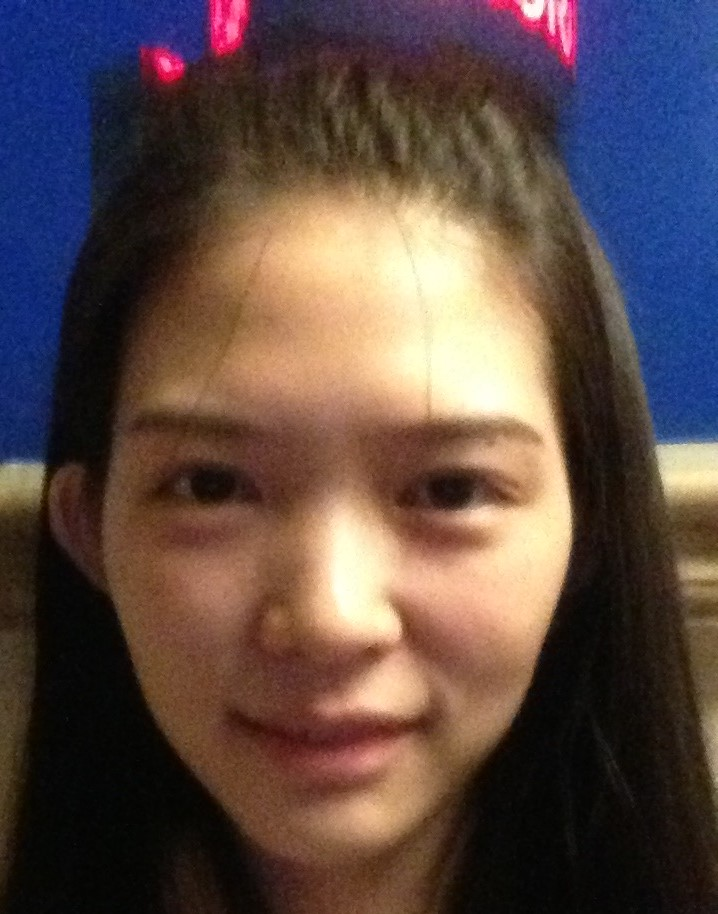

In [3]:
img = Image.open('data/samples/modelling/train/Shiqing/shiqing (9).JPG')
display(img)

### Phase 01: Face detection

In [4]:
# Initializing MTCNN
mtcnn = MTCNN(
    image_size=160, margin=0, min_face_size=20,
    thresholds=[0.6, 0.7, 0.7], factor=0.709, post_process=True,
    device=device
)

# Defining parameters
data_dir = 'data/samples/modelling/train'
cropped_data_dir = 'data/samples/modelling/train_cropped'

batch_size = 32
workers = 0 if os.name == 'nt' else 8

# Create train dataset
train_dataset = datasets.ImageFolder(data_dir, transform=transforms.Resize((512, 512)))

# Modify sample paths for saving cropped images
train_dataset.samples = [
    (p, p.replace(data_dir, cropped_data_dir))
    for p, _ in train_dataset.samples
]

# Create data loader
loader = DataLoader(
    train_dataset,
    num_workers=workers,
    batch_size=batch_size,
    collate_fn=training.collate_pil 
)

# Loop over the data loader
for i, (x, y) in enumerate(loader):
    # Process each batch
    for img, path in zip(x, y):
        mtcnn(img, save_path=path)  
    print('\rBatch {} of {}'.format(i + 1, len(loader)), end='')

# Cleanup
del mtcnn

Batch 15 of 15

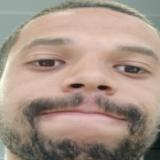

In [5]:
img = Image.open('data/samples/modelling/train_cropped/Charlie/IMG20230629113011.jpg')
display(img)

----

### Phase 02: Face recognition 

#### Train Dataset

In [6]:
# Data transformation
trans = transforms.Compose([
    transforms.Resize((160,160)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
])

# Importing dataset
dataset = datasets.ImageFolder(cropped_data_dir, transform=trans)
len(dataset)

466

#### Train/Validation Split

In [7]:
train_dataset, val_dataset = random_split(dataset,[376,90] )

len(train_dataset), len(val_dataset)

(376, 90)

#### Data Loaders

In [8]:
batch_size = 32

train_loader = DataLoader(dataset=train_dataset, batch_size=32)
val_loader = DataLoader(dataset=val_dataset, batch_size=32)

In [9]:
img, label = next(iter(val_loader))
img.shape, label.shape

(torch.Size([32, 3, 160, 160]), torch.Size([32]))

#### Understanding the model

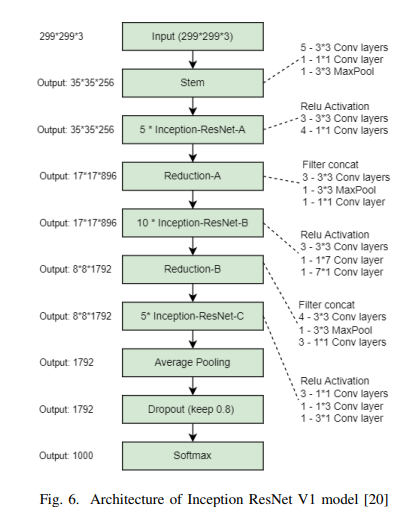

**conv2d_1a**
This layer applies a 3x3 convolution with 32 filters to the input image, followed by batch normalization and ReLU activation.

**conv2d_2a**
Another 3x3 convolutional layer with 32 filters, followed by batch normalization and ReLU activation.

**conv2d_2b**
A 3x3 convolutional layer with 64 filters, followed by batch normalization and ReLU activation.

**maxpool_3a**
Max pooling layer with a kernel size of 3x3 and a stride of 2.

**conv2d_3b**
A 1x1 convolutional layer with 80 filters, followed by batch normalization and ReLU activation.

**conv2d_4a**
A 3x3 convolutional layer with 192 filters, followed by batch normalization and ReLU activation.

**conv2d_4b**
A 3x3 convolutional layer with 256 filters and a stride of 2, followed by batch normalization and ReLU activation.

**repeat_1**
This is a sequence of repeated blocks (Block35), each containing three branches with different convolutional operations.

**mixed_6a**
Mixed convolutional layer combining different types of convolutions and pooling operations.

**repeat_2**
Another sequence of repeated blocks (Block17), similar to repeat_1.

 (avgpool_1a): AdaptiveAvgPool2d(output_size=1)
 (dropout): Dropout(p=0.6, inplace=False)
 (last_linear): Linear(in_features=1792, out_features=512, bias=False)
 (last_bn): BatchNorm1d(512, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
 (logits): Linear(in_features=512, out_features=46, bias=True)


#### Building the model

In [10]:
resnet = InceptionResnetV1(
    pretrained='vggface2',
    num_classes=46
).to(device)
#resnet

In [11]:
list(resnet.children())[-1]

Linear(in_features=512, out_features=8631, bias=True)

In [12]:
class FaceRecognizer(nn.Module):
    def __init__(self):
        super().__init__()
        resnet = InceptionResnetV1( pretrained='vggface2').eval().to(device)
        self.features = nn.Sequential(*list(resnet.children())[:-5])
        self.avgpool_1a = resnet.avgpool_1a
        self.dropout = resnet.dropout
        self.last_linear = resnet.last_linear
        self.last_bn = resnet.last_bn
        self.logits= nn.Linear(512, 46)

    def forward(self, x):
        out = self.features(x)
        out = self.avgpool_1a(out)
        out = self.dropout(out)
        out = torch.flatten(out, 1)
        out = self.last_linear(out)
        out = self.last_bn(out)
        out = self.logits(out)
        return out

tmpModel = FaceRecognizer().to(device)
tmpImg, _ = next(iter(train_loader))
tmpImg = tmpImg.to(device)
tmpOut = tmpModel(tmpImg)
tmpOut.shape

torch.Size([32, 46])

In [13]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() 
    acc = (correct / len(y_pred)) * 100 
    return acc

In [14]:
# Freezing 
model = FaceRecognizer().to(device)
for params in model.features.parameters():
    params.requires_grad = False
for params in model.avgpool_1a.parameters():
    params.requires_grad = False
for params in model.dropout.parameters():
    params.requires_grad = False
for params in model.last_linear.parameters():
    params.requires_grad = False
for params in model.last_bn.parameters():
    params.requires_grad = False

train_losses = []; train_accs = []
validation_losses = []; validation_accs = []

lr = 0.01
n_epochs = 15

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr)

for epoch in range(n_epochs):
    # Training Loop
    model.train()
    train_loss, train_acc = 0, 0
    
    for x_batch, y_batch in train_loader:  
            
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        
        y_logits = model(x_batch)
        loss = loss_fn(y_logits, y_batch)
        
        train_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()    
        optimizer.step()
        
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) # turn logits -> pred probs -> pred labels
        train_acc += accuracy_fn(y_true=y_batch, y_pred=y_pred) 
        
    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    
    train_acc /= len(train_loader)
    train_accs.append(train_acc)
    
    # Validation Loop
    model.eval()
    validation_loss , validation_acc = 0, 0
    
    with torch.no_grad():
        for x_val, y_val in val_loader:

            x_val = x_val.to(device)
            y_val = y_val.to(device)

            y_logits = model(x_val)
            val_loss = loss_fn(y_logits, y_val)
            
            validation_loss += val_loss.item()
            
            y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)
            validation_acc += accuracy_fn(y_true=y_val, y_pred=y_pred) 
        
    validation_loss /= len(val_loader)
    validation_losses.append(validation_loss)
    
    validation_acc /= len(val_loader)
    validation_accs.append(validation_acc)
    
    # Print out what's happening every 10 epochs
    print(f"Epoch: {epoch} | Loss: {train_loss:.5f}, Accuracy: {train_acc:.2f}% | val loss: {validation_loss:.5f}, val acc: {validation_acc:.2f}%")

Epoch: 0 | Loss: 3.73409, Accuracy: 4.25% | val loss: 3.31197, val acc: 15.54%
Epoch: 1 | Loss: 3.02216, Accuracy: 34.81% | val loss: 2.72179, val acc: 56.25%
Epoch: 2 | Loss: 2.40841, Accuracy: 66.49% | val loss: 2.24693, val acc: 72.76%
Epoch: 3 | Loss: 1.92495, Accuracy: 80.30% | val loss: 1.86753, val acc: 76.12%
Epoch: 4 | Loss: 1.55849, Accuracy: 85.33% | val loss: 1.56829, val acc: 83.41%
Epoch: 5 | Loss: 1.27844, Accuracy: 88.80% | val loss: 1.34608, val acc: 85.98%
Epoch: 6 | Loss: 1.08605, Accuracy: 89.67% | val loss: 1.17641, val acc: 88.30%
Epoch: 7 | Loss: 0.92985, Accuracy: 92.71% | val loss: 1.03842, val acc: 88.30%
Epoch: 8 | Loss: 0.81508, Accuracy: 92.88% | val loss: 0.92961, val acc: 89.34%
Epoch: 9 | Loss: 0.72309, Accuracy: 94.53% | val loss: 0.85425, val acc: 91.43%
Epoch: 10 | Loss: 0.64572, Accuracy: 95.05% | val loss: 0.78403, val acc: 92.47%
Epoch: 11 | Loss: 0.59715, Accuracy: 95.57% | val loss: 0.73120, val acc: 92.47%
Epoch: 12 | Loss: 0.54484, Accuracy: 95

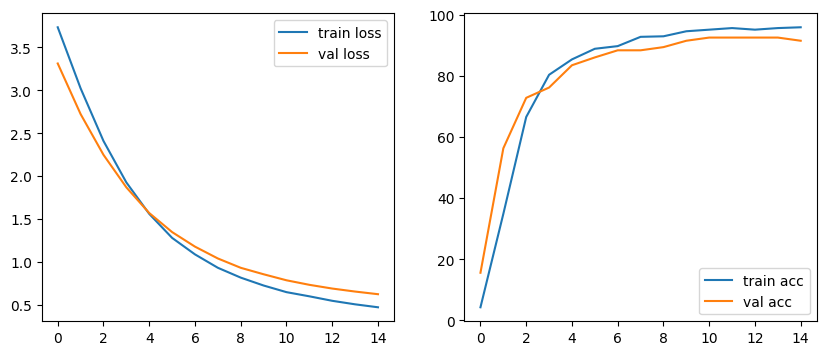

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].plot(train_losses, label="train loss")
ax[0].plot(validation_losses, label="val loss")
ax[0].legend()

ax[1].plot(train_accs, label="train acc")
ax[1].plot(validation_accs, label="val acc")
ax[1].legend();

plt.show()

---

#### Test

In [16]:
# Initializing MTCNN
mtcnn = MTCNN(
    image_size=160, margin=0, min_face_size=20,
    thresholds=[0.6, 0.7, 0.7], factor=0.709, post_process=True,
    device=device
)

# Defining parameters
data_dir = 'data/samples/modelling/test'
test_cropped_data_dir = 'data/samples/modelling/test_cropped'

batch_size = 32
workers = 0 if os.name == 'nt' else 8

# Create train dataset
test_dataset = datasets.ImageFolder(data_dir, transform=transforms.Resize((512, 512)))

# Modify sample paths for saving cropped images
test_dataset.samples = [
    (p, p.replace(data_dir, cropped_data_dir))
    for p, _ in test_dataset.samples
]

# Create data loader
loader = DataLoader(
    test_dataset,
    num_workers=workers,
    batch_size=batch_size,
    collate_fn=training.collate_pil  
)

# Loop over the data loader
for i, (x, y) in enumerate(loader):
    # Process each batch
    for img, path in zip(x, y):
        mtcnn(img, save_path=path)  
    print('\rBatch {} of {}'.format(i + 1, len(loader)), end='')

# Cleanup
del mtcnn

Batch 2 of 2

In [17]:
# to bring all classes
dataset = datasets.ImageFolder(cropped_data_dir, transform=trans)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

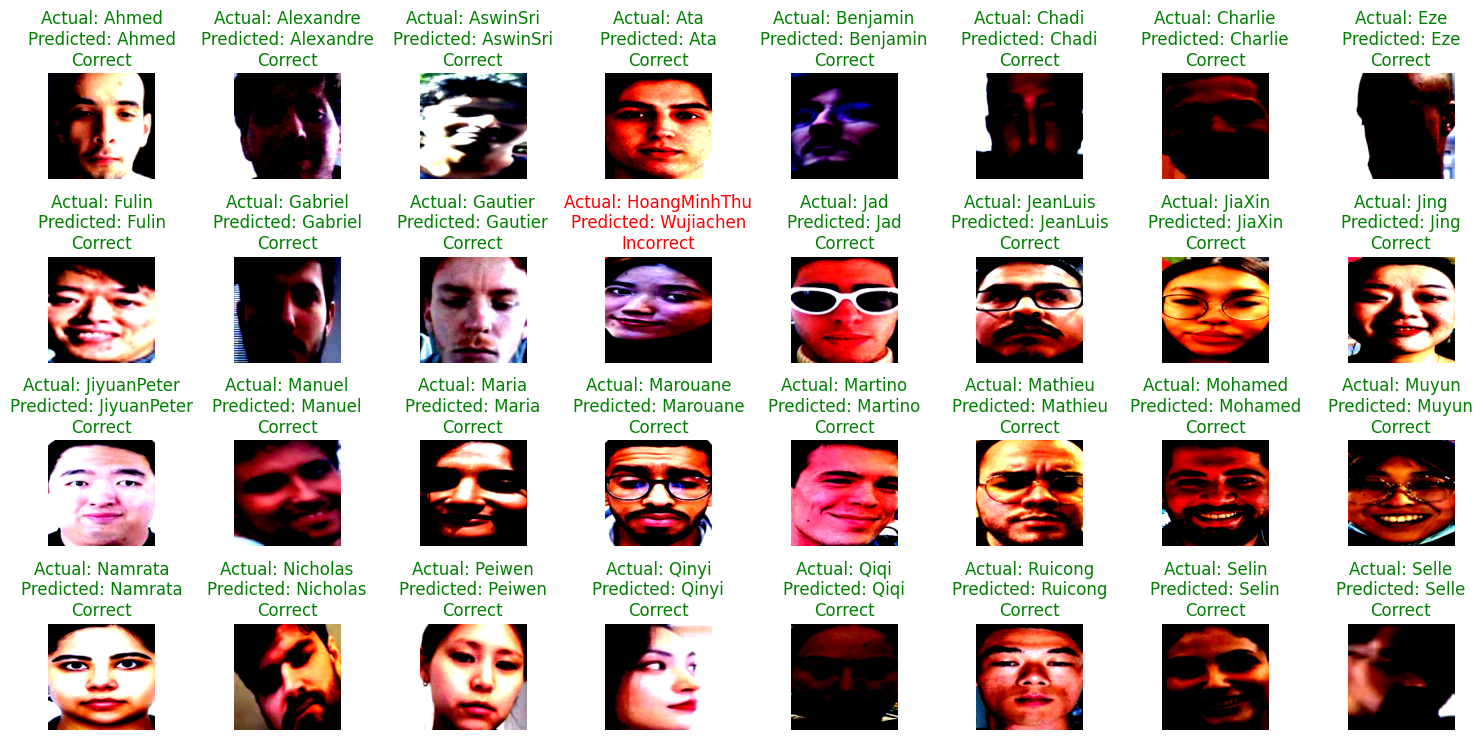

In [24]:
# Data transformation
trans = transforms.Compose([
    transforms.Resize((160,160)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
])

# Importing dataset
test_dataset = ImageFolder(test_cropped_data_dir, transform=trans)

batch_size = 32

# Create data loader for the entire test dataset
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size)

class_to_idx = dataset.class_to_idx
idx_to_class_all = {idx: class_name for class_name, idx in dataset.class_to_idx.items()}
idx_to_class_test = {idx: class_name for class_name, idx in test_dataset.class_to_idx.items()}

# Set the model to evaluation mode
model.eval()

# Initialize variables to store accuracy and incorrect predictions
correct_predictions = 0
total_predictions = 0

# Determine the number of rows and columns for subplot layout
num_cols = 8  # Assuming 8 columns
num_rows = (batch_size + num_cols - 1) // num_cols

# Initialize subplot
fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 7.5))

# Iterate over the test dataset and display images along with actual and predicted labels for one batch
for i, (images, labels) in enumerate(test_loader):
    # Perform inference
    with torch.no_grad():
        outputs = model(images)
    probabilities = torch.softmax(outputs, dim=1)
    predicted_classes = torch.argmax(probabilities, dim=1)
    predicted_class_names = [idx_to_class_all[idx] for idx in predicted_classes.tolist()]
    actual_class_names = [idx_to_class_test[label.item()] for label in labels]
    
    # Convert images to numpy arrays
    image_np = images.permute(0, 2, 3, 1).numpy()  
    
    # Display images along with actual and predicted labels
    for j in range(len(images)):
        # Check if prediction is correct
        if total_predictions < batch_size:
            if predicted_class_names[j] == actual_class_names[j]:
                correct_predictions += 1
                axs[total_predictions // num_cols, total_predictions % num_cols].set_title(f'Actual: {actual_class_names[j]}\nPredicted: {predicted_class_names[j]}\nCorrect', color='green')
            else:
                axs[total_predictions // num_cols, total_predictions % num_cols].set_title(f'Actual: {actual_class_names[j]}\nPredicted: {predicted_class_names[j]}\nIncorrect', color='red')
                axs[total_predictions // num_cols, total_predictions % num_cols].plot([0, 1], [0, 1], color='red', linestyle='-', linewidth=2)  # Draw a cross over the image
            
            axs[total_predictions // num_cols, total_predictions % num_cols].imshow(image_np[j])
            axs[total_predictions // num_cols, total_predictions % num_cols].axis('off')
            
            total_predictions += 1
        else:
            break


plt.tight_layout()
plt.show()


In [23]:
# Set the model to evaluation mode
model.eval()

# Initialize variables to store accuracy and incorrect predictions
correct_predictions = 0
total_predictions = 0

# Iterate over the test dataset and accumulate correct predictions
for epoch in range(15):
    for i, (images, labels) in enumerate(test_loader):
        # Perform inference
        with torch.no_grad():
            outputs = model(images)
        probabilities = torch.softmax(outputs, dim=1)
        predicted_classes = torch.argmax(probabilities, dim=1)
        predicted_class_names = [idx_to_class_all[idx] for idx in predicted_classes.tolist()]
        actual_class_names = [idx_to_class_test[label.item()] for label in labels]

        # Count correct predictions
        for j in range(len(images)):
            if total_predictions < len(test_dataset):
                if predicted_class_names[j] == actual_class_names[j]:
                    correct_predictions += 1
                total_predictions += 1

# Calculate and print accuracy
accuracy = correct_predictions / total_predictions * 100
print(f'Accuracy after 15 epochs: {accuracy:.2f}%')


Accuracy after 15 epochs: 97.50%


#### Checking combined images

In [25]:
mtcnn = MTCNN(
    image_size=160, margin=0, min_face_size=20,
    thresholds=[0.6, 0.7, 0.7], factor=0.709, post_process=True,
    device=device
)

In [26]:
transform = transforms.Compose([
    transforms.Resize((160,160)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
])

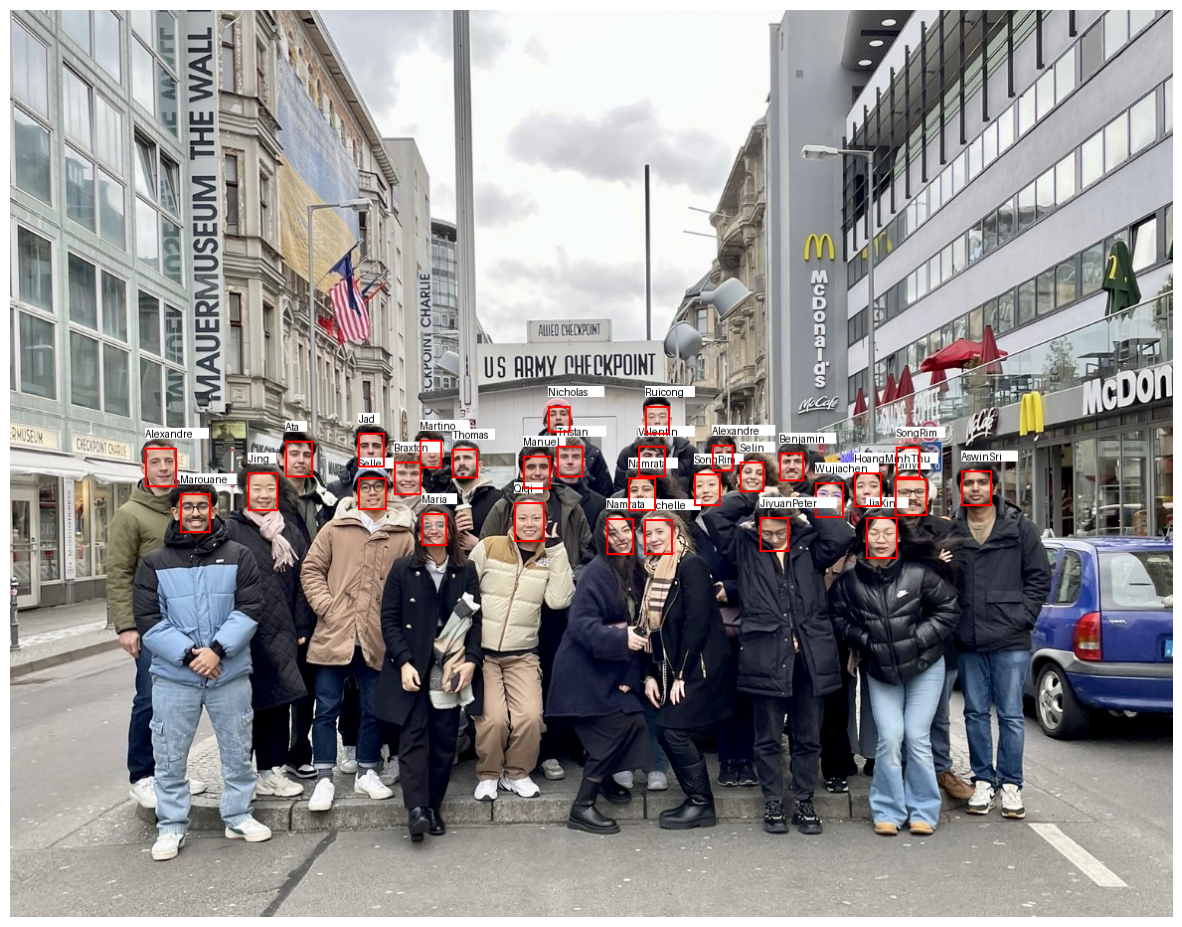

In [27]:
# Load the image
frame = Image.open('data/samples/modelling/all/IMG_9935.jpg')

# Detect faces in the image
boxes, _ = mtcnn.detect(frame)

# Create a copy of the image for drawing
frame_draw = frame.copy()
draw = ImageDraw.Draw(frame_draw)

# Iterate over detected faces
for box in boxes:
    # Convert box coordinates to integers
    box = [int(coord) for coord in box.tolist()]
    
    # Crop and preprocess the detected face
    face = frame.crop(box)
    face_tensor = transform(face).unsqueeze(0)
    
    # Perform inference using the ResNet model to predict the label
    with torch.no_grad():
        output = model(face_tensor)
    probability = torch.softmax(output, dim=1)
    predicted_class_index = torch.argmax(probability, dim=1).item()
    predicted_class_name = idx_to_class_all[predicted_class_index]

    # Draw the bounding box and predicted label on the image
    draw.rectangle(box, outline=(255, 0, 0), width=2)
    text_position = (box[0], box[1] - 20)  # Position the text above the bounding box
    text = predicted_class_name
    text_color = (0, 0, 0)  # Black text color
    text_background = (255, 255, 255)  # White background color
    draw.rectangle([text_position, (text_position[0] + len(text) * 7, text_position[1] + 10)], fill=text_background)
    font = ImageFont.load_default()  # Load the default font
    draw.text(text_position, text, fill=text_color, font=font)

plt.figure(figsize=(15, 15)) 
plt.imshow(frame_draw)
plt.axis('off')
plt.show()

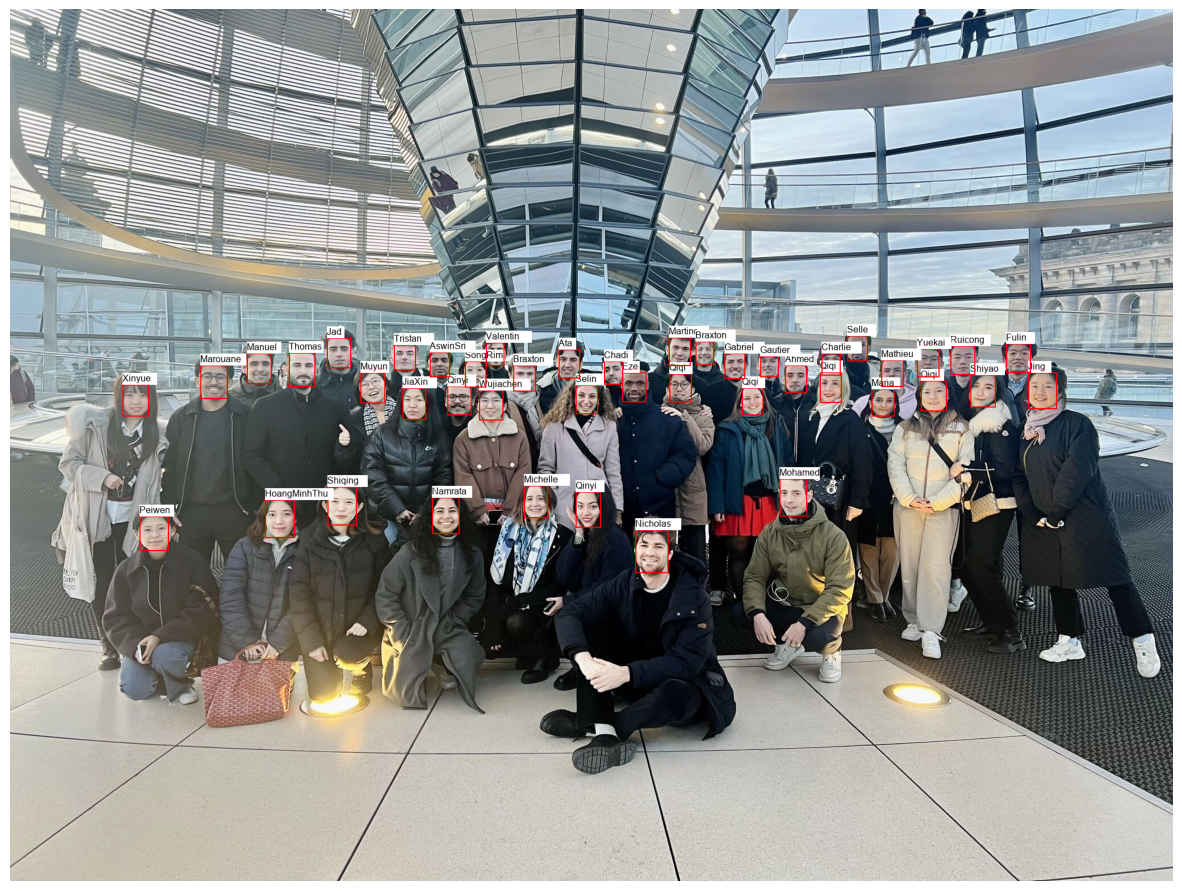

In [30]:
# Load the image
frame = Image.open('data/samples/modelling/all/1707671603618.jpg')

# Detect faces in the image
boxes, _ = mtcnn.detect(frame)

# Create a copy of the image for drawing
frame_draw = frame.copy()
draw = ImageDraw.Draw(frame_draw)

# Iterate over detected faces
for box in boxes:
    # Convert box coordinates to integers
    box = [int(coord) for coord in box.tolist()]
    
    # Crop and preprocess the detected face
    face = frame.crop(box)
    face_tensor = transform(face).unsqueeze(0)
    
    # Perform inference using the ResNet model to predict the label
    with torch.no_grad():
        output = model(face_tensor)
    probability = torch.softmax(output, dim=1)
    predicted_class_index = torch.argmax(probability, dim=1).item()
    predicted_class_name = idx_to_class_all[predicted_class_index]

    # Draw the bounding box and predicted label on the image
    draw.rectangle(box, outline=(255, 0, 0), width=2)
    text_position = (box[0], box[1] - 20)  # Position the text above the bounding box
    text = predicted_class_name
    text_color = (0, 0, 0)  # Black text color
    text_background = (255, 255, 255)  # White background color
    draw.rectangle([text_position, (text_position[0] + len(text) * 10, text_position[1] + 20)], fill=text_background)
    
    # Increase font size
    font_size = 16
    font = ImageFont.truetype("arial.ttf", font_size)
    
    draw.text(text_position, text, fill=text_color, font=font)

plt.figure(figsize=(15, 15)) 
plt.imshow(frame_draw)
plt.axis('off')
plt.show()


In [38]:
# Number of correct labels
37/42

0.8809523809523809

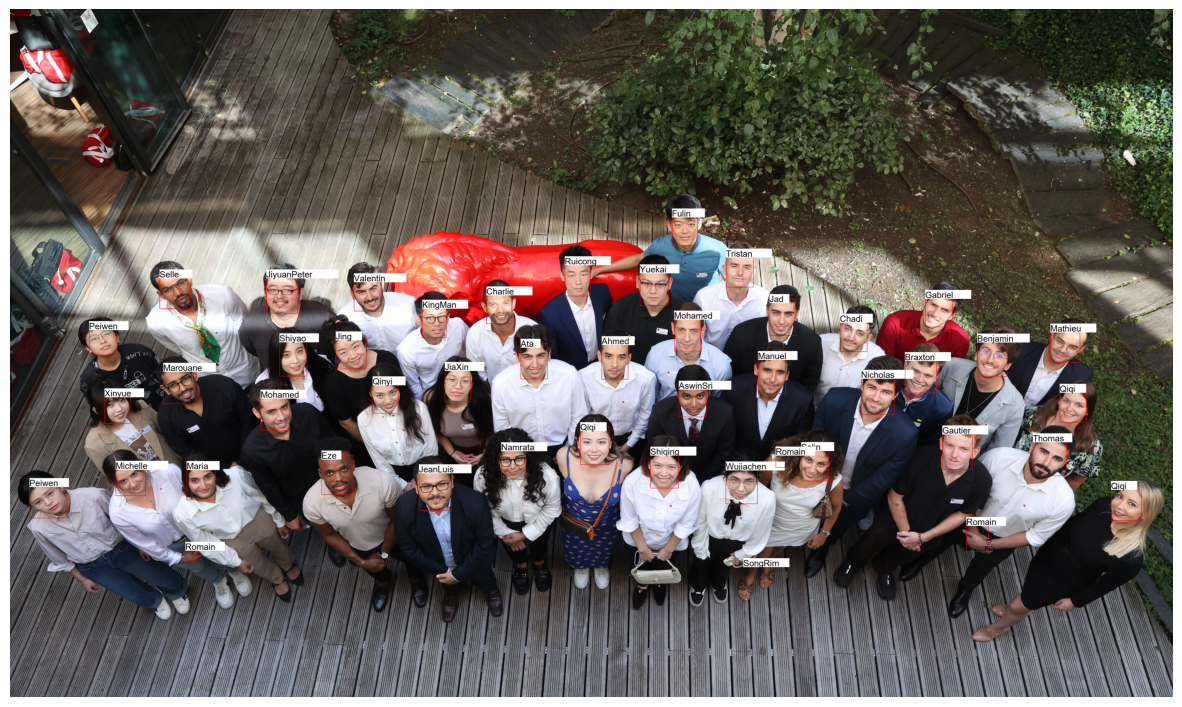

In [43]:
# Load the image
frame = Image.open('data/samples/modelling/all/picture 1.jpg')

# Detect faces in the image
boxes, _ = mtcnn.detect(frame)

# Create a copy of the image for drawing
frame_draw = frame.copy()
draw = ImageDraw.Draw(frame_draw)

# Iterate over detected faces
for box in boxes:
    # Convert box coordinates to integers
    box = [int(coord) for coord in box.tolist()]
    
    # Crop and preprocess the detected face
    face = frame.crop(box)
    face_tensor = transform(face).unsqueeze(0)
    
    # Perform inference using the ResNet model to predict the label
    with torch.no_grad():
        output = model(face_tensor)
    probability = torch.softmax(output, dim=1)
    predicted_class_index = torch.argmax(probability, dim=1).item()
    predicted_class_name = idx_to_class_all[predicted_class_index]

    # Draw the bounding box and predicted label on the image
    draw.rectangle(box, outline=(255, 0, 0), width=2)
    text_position = (box[0], box[1] - 20)  # Position the text above the bounding box
    text = predicted_class_name
    text_color = (0, 0, 0)  # Black text color
    text_background = (255, 255, 255)  # White background color
    draw.rectangle([text_position, (text_position[0] + len(text) * 30, text_position[1] + 40)], fill=text_background)
    
    # Increase font size
    font_size = 40
    font = ImageFont.truetype("arial.ttf", font_size)
    
    draw.text(text_position, text, fill=text_color, font=font)

plt.figure(figsize=(15, 15)) 
plt.imshow(frame_draw)
plt.axis('off')
plt.show()


### Extra Step: Live detection

In [37]:
# Initialize the video capture
video_capture = cv2.VideoCapture(0)

# Function to draw labels and boxes on the image
def draw_labels_and_boxes(frame, boxes, labels):
    frame_pil = Image.fromarray(frame)
    draw = ImageDraw.Draw(frame_pil)
    font = ImageFont.load_default()  # Load the default font
    
    # Iterate over detected faces
    for box, label in zip(boxes, labels):
        # Convert box coordinates to integers
        box = [int(coord) for coord in box.tolist()]
        
        # Draw the bounding box
        draw.rectangle(box, outline=(255, 0, 0), width=2)
        
        # Position the text above the bounding box
        text_position = (box[0], box[1] - 20)
        
        # Draw the label
        text = label
        text_color = (0, 0, 0)  # Black text color
        text_background = (255, 255, 255)  # White background color
        draw.rectangle([text_position, (text_position[0] + len(text) * 7, text_position[1] + 20)], fill=text_background)
        draw.text(text_position, text, fill=text_color, font=font)
    
    frame_with_labels = cv2.cvtColor(np.array(frame_pil), cv2.COLOR_RGB2BGR)
    return frame_with_labels

# Run the camera loop
while True:
    # Read a frame from the video capture
    ret, frame = video_capture.read()
    
    # Detect faces in the frame
    boxes, _ = mtcnn.detect(frame)
    
    # Check if faces are detected
    if boxes is not None:
        # Convert the frame to RGB (PIL format) for drawing labels and boxes
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        
        # Iterate over detected faces
        labels = []
        for box in boxes:
            # Crop and preprocess the detected face
            face = frame[int(box[1]):int(box[3]), int(box[0]):int(box[2])]
            face_pil = Image.fromarray(face)
            face_tensor = transform(face_pil).unsqueeze(0)
            
            # Perform inference using the ResNet model to predict the label
            with torch.no_grad():
                output = model(face_tensor)
            probability = torch.softmax(output, dim=1)
            predicted_class_index = torch.argmax(probability, dim=1).item()
            predicted_class_name = idx_to_class_all[predicted_class_index]
            labels.append(predicted_class_name)
        
        # Draw labels and boxes on the frame
        frame_with_labels = draw_labels_and_boxes(frame_rgb, boxes, labels)
        
        # Display the frame with labels and boxes
        cv2.imshow('Video Stream', frame_with_labels)
    else:
        # Display the original frame if no faces are detected
        cv2.imshow('Video Stream', frame)
    
    # Check for user input
    key = cv2.waitKey(1) & 0xff
    
    # Save the image on pressing 's'
    if key == ord('s'):
        timestr = time.strftime("%Y-%m-%d %H:%M:%S")
        filename = src + timestr + ".jpg"
        cv2.imwrite(filename, frame)
        print("Saving image: " + filename)
    
    # Exit the loop on pressing 'q'
    if key == ord('q'):
        break

# Release the video capture and close all windows
video_capture.release()
cv2.destroyAllWindows()
cv2.waitKey(1)
print("Done")


Done
